In [1]:
%matplotlib inline

# Module 12 - Programming Assignment

## Directions

1. Change the name of this file to be your JHED id as in `jsmith299.ipynb`. Because sure you use your JHED ID (it's made out of your name and not your student id which is just letters and numbers).
2. Make sure the notebook you submit is cleanly and fully executed. I do not grade unexecuted notebooks.
3. Submit your notebook back in Blackboard where you downloaded this file.

*Provide the output **exactly** as requested*

# The Problem

When we last left our agent in Modules 1 and 11, it was wandering around a world filled with plains, forests, swamps, hills and mountains. This presupposes a map with known terrain:

```
......
...**.
...***
..^...
..~^..
```

but what if all we know is that we have some area of interest, that we've reduced to a GPS grid:

```
??????
??????
??????
??????
??????
```

and the agent has to determine what kind of terrain is to the left, front and right of it?

Assuming the agent has a very simple visual sensor that constructs a 4x4 grayscale image for each of the three directions, it might it could see something like this:

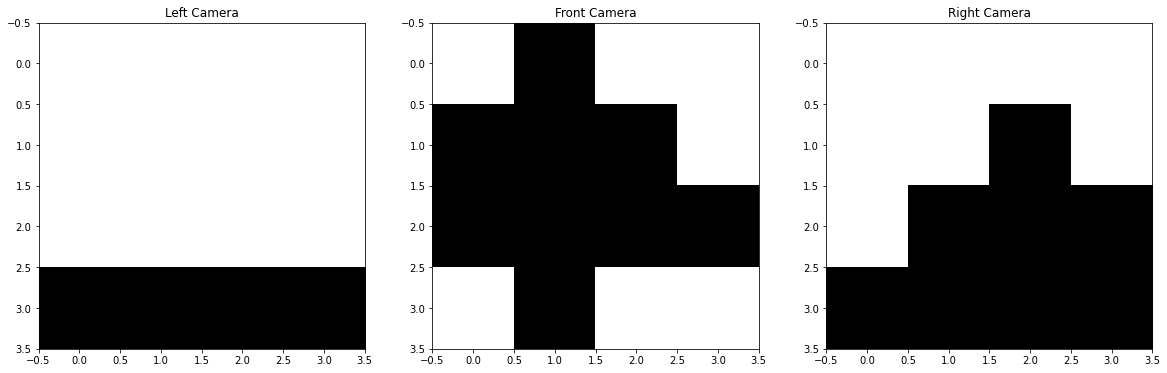

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

plain =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 1.0, 1.0, 1.0]
forest = [0.0, 1.0, 0.0, 0.0,1.0, 1.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0,0.0, 1.0, 0.0, 0.0]
hills =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 1.0, 0.0,0.0, 1.0, 1.0, 1.0,1.0, 1.0, 1.0, 1.0]
swamp =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 0.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0]

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)
pixels = np.array([255 - p * 255 for p in plain], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Left Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 2)
pixels = np.array([255 - p * 255 for p in forest], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Front Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 3)
pixels = np.array([255 - p * 255 for p in hills], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Right Camera")
axes.imshow(pixels, cmap='gray')

plt.show()
plt.close()

which would be plains, forest and hills respectively.

## The Assignment

For this programming assignment your tasks are:

1. Write a logistic regression that simply determines if something is a hill or not (two class problem). 
2. You will also evaluate that logistic regression by generating a *confusion matrix*.

For a starting point, refer to the Pseudocode and the Self-Check.

## Data

We have clean examples of the different types of terrain but based on the location, the registration can be a bit off for some of the types and the visual sensor is often noisy.

Here are the clean examples with different registrations: 

In [3]:
clean_data = {
    "plains": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, "plains"]
    ],
    "forest": [
        [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, "forest"],
        [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, "forest"]
    ],
    "hills": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, "hills"]
    ],
    "swamp": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "swamp"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, "swamp"]        
    ]
}

Let's create a function that allows us to view any of these:

In [4]:
def view_sensor_image(data):
    figure = plt.figure(figsize=(4,4))
    axes = figure.add_subplot(1, 1, 1)
    pixels = np.array([255 - p * 255 for p in data[:-1]], dtype='uint8')
    pixels = pixels.reshape((4, 4))
    axes.set_title( "Left Camera:" + data[-1])
    axes.imshow(pixels, cmap='gray')
    plt.show()
    plt.close()

"I think that I shall never see a thing so lovely as a tree."

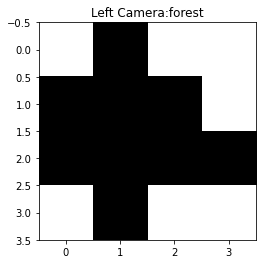

In [5]:
view_sensor_image( clean_data[ "forest"][0])

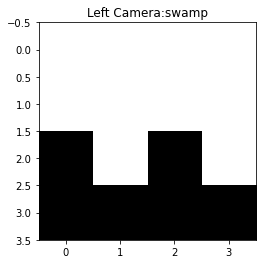

In [6]:
view_sensor_image( clean_data["swamp"][0])

The data that comes in, however, is noisy. The values are never exactly 0 and 1. In order to mimic this we need a `blur` function.

We will assume that noise is normally distributed. For values that should be 0, the noisy values are distributed $N(0.10, 0.05)$. For values should be 1, the noisy values are distributed $N(0.9, 0.10)$.

In [7]:
def blur( data):
    def apply_noise( value):
        if value < 0.5:
            v = random.gauss( 0.10, 0.05)
            if v < 0.0:
                return 0.0
            if v > 0.75:
                return 0.75
            return v
        else:
            v = random.gauss( 0.90, 0.10)
            if v < 0.25:
                return 0.25
            if v > 1.00:
                return 1.00
            return v
    noisy_readings = [apply_noise( v) for v in data[0:-1]]
    return noisy_readings + [data[-1]]

We can see how this affects what the agent *actually* sees.

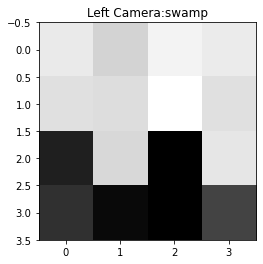

In [8]:
view_sensor_image( blur( clean_data["swamp"][0]))

We need four (4) functions:

1. `generate_data`
2. `learn_model`
3. `apply_model`
4. `evaluate`

### generate_data

`generate_data` has been written for you.

* clean_data - the clean versions of the "bitmaps" for each of the terrain types
* n - the number of samples for "in the class" (1) and "not in the class" (0) to generate.
* label - the label to chose as "in the class".

For example,

`generate_data( clean_data, 100, "hills")`

generates 100 hills, 100 not hills and has transformed the String labels into 1 and 0, respectively.

### `learn_model`

`learn_model` is the function that takes in training data and actually learns the logistic regression model. If you're up to it, you can implement a vectorized version using Numpy but you might start with the loopy version first.

*In the lecture, I mentioned that you usually should mean normalize your data but you don't need to do that in this case because the data is already on the range 0-1.*

I should also mention that gradient descent is not the usual approach to linear regression because the error function actually has an *exact* solution. However, in the case of large data sets, the exact solution often fails and in any case, the use of gradient descent will prepare you for neural networks next week.

When verbose is True, you should print out the error so you can see that it is getting smaller. 

When developing your algorithm, you need to watch the error so you'll set verbose=True to start. You should print it out every iteration and make sure it is declining. You'll have to experiment with both epsilon and alpha; and it doesn't hurt to make alpha adaptive (if the error increases, make alpha = alpha / 10).

When you know that your algorithm is working, change your code so that the error is printed out only every 1,000 iterations (it takes a lot of iterations for this problem to converge, depending on your parameter values--start early).

`learn_model` returns the List of Thetas.

### `apply_model`

`apply_model` takes a List of Thetas (the model) and either labeled or unlabeled data. If the data is unlabeled, it will return predictions for each observation as a Tuple of the inferred value (0 or 1) and the actual probability (so something like (1, 0.73) or (0, 0.29). We always return the class with the higher probability.

If the data are labeled, you will return a Tuple of the actual value (0 or 1) and the predicted value (0 or 1). In this case, you return a List of something like [(0, 1), (1, 1), (0, 0), (1, 0)].

### `evaluate`

Ideally, we should be running 10 fold cross validation on this problem but...that might take a while so we're going to just go ahead with a simple evaluation. We're interested not only in the error rate but the overall "confusion" of the model.

The `evaluate` takes the results of `apply_model` when labeled=True and prints out the error rate and a confusion matrix.

---

Why `labeled=True` or `labeled=False`? While we only have labeled data right now, for model evaluation. In the future, you would need to use this function to do actual classification. In that case, `labeled=False`. Because in the long run, that's the default usage, we use `False` as the default.

---

**As always when working with Lists or Lists of Lists, be very careful when you are modifying these items in place that this is what you want.**

<a id="calculate_error"></a>
## calculate_error

Calculates the logistic regression error.

In [21]:
def calculate_error(thetas, data):
    total_error = 0
    n = len(data)
    for record in data:
        xs = record[0]
        actual = record[1]
        current = (1/(1 + math.e**((-1)*sum([thetas[i]*xs[i] for i in range(len(xs))]))))
        if (current <= 0) or (1 - current <= 0):
            total_error += 1
        else:
            total_error += ((actual)*(math.log(current))+(1-actual)*(1-current))
    return (-1/n)*(total_error)

<a id="derivative"></a>
## derivative

Calculate the derivative of the logistic regression error.

In [22]:
def derivative(j, thetas, data):
    total_error = 0
    n = len(data)
    for record in data:
        xs = record[0]
        actual = record[1]
        current = (1/(1 + math.e**((-1)*sum([thetas[i]*xs[i] for i in range(len(xs))]))))
        total_error += ((current-actual)*(xs[j]))
    return (1/n)*(total_error)

---

Put your helper functions above here.

## Main Functions

Use `generate_data` to generate a balanced set of blurred "hills" and "not-hills" examples to test that the function is working.

In [23]:
def generate_data( data, n, key_label):
    labels = list(data.keys())
    labels.remove(key_label)

    total_labels = len(labels)
    result = []
    # create n "not label" and code as y=0
    count = 1
    while count <= n:
        label = labels[count % total_labels]
        datum = blur(random.choice(data[label]))
        xs = datum[0:-1]
        result.append((xs, 0))
        count += 1

    # create n "label" and code as y=1
    for _ in range(n):
        datum = blur(random.choice(data[key_label]))
        xs = datum[0:-1]
        result.append((xs, 1))
    random.shuffle(result)
    return result

In [24]:
#results = generate_data( clean_data, 10, "hills")
#for result in results:
#    print(result)

<a id="learn_model"></a>
## learn_model

Returns a set of thetas that the data was trained to work against.

In [75]:
def learn_model(data, verbose=False):
    m = len(data[0][0])
    thetas = [random.uniform(-1, 1) for x in range(m)]
    last_error, epsilon, alpha = 0, 0.0000001, 0.02
    current_error = calculate_error(thetas, data)
    iterations = 0
    while (abs(last_error - current_error) > epsilon) and (iterations < 100000) and (abs(current_error) > 0.01): # i can't wait this long
        new_thetas = []
        for j in range(m):
            new_thetas.append(thetas[j] - (alpha*derivative(j, thetas, data)))
        thetas = new_thetas
        last_error = current_error
        current_error = calculate_error(thetas, data)
        if (verbose == True) and (iterations % 1000 == 0):
            print('Iteration: ' + str(iterations) + ' CurrentError: ' + str(current_error))
        if last_error < current_error:
            alpha /= 5
        iterations += 1    
    print('Iteration: ' + str(iterations) + ' CurrentError: ' + str(current_error))
    return thetas

<a id="apply_model"></a>
## apply_model

Applies the model (thetas) to a given set of labelled or unlabelled data.

In [76]:
def apply_model(model, test_data, labeled=False):
    results = []
    for record in test_data:
        xs = record[0]
        actual = record[1]
        predicted_raw = (1/(1 + math.e**((-1)*sum([model[i]*xs[i] for i in range(len(xs))]))))
        predicted = 0
        if predicted_raw >= 0.5:
            predicted = 1
        results.append((actual, predicted))
    return results

<a id="evaluate"></a>
## evaluate

Checks the accuracy of the application of the model that was applied. Will print out a confusion matrix.

In [77]:
def evaluate(results):
    total = len(results)
    true_hill, false_hill, true_nhill, false_nhill = 0, 0, 0, 0
    for result in results:
        if result[0] == 1:
            if result[0] == result[1]:
                true_hill += 1
            else:
                false_nhill += 1
        else:
            if result[0] == result[1]:
                true_nhill += 1
            else:
                false_hill += 1
    error = ((false_hill+false_nhill)/total)
    print('Error: ' + str(error))
    print('\r\nConfusion Matrix')
    print('True Hills: ' + str(true_hill))
    print('False Hills: ' + str(false_hill))
    print('False Non-Hills: ' + str(false_nhill))
    print('True Non-Hills: ' + str(true_nhill))

## Use your code

Use `generate_data` to generate 100 blurred "hills" examples balanced with 100 "non hills" examples and use this as your test data. Set labeled=True. Print out the first 10 results, one per line.

In [78]:
train_data = generate_data(clean_data, 100, "hills")

In [79]:
test_data = generate_data(clean_data, 100, "hills")

Use `learn_model` to learn a logistic regression model for classifying sensor images as "hills" or "not hills". Use your `generate_data` function to generate a training set of size 100 for "hills". **Set Verbose to True**

In [80]:
model = learn_model(train_data, True)

Iteration: 0 CurrentError: 0.09820486370641142
Iteration: 1000 CurrentError: 0.04824288281526428
Iteration: 1701 CurrentError: 0.009952174816757791


In [81]:
print(model)

[0.10258777363341283, -0.48648119028232895, -0.39158626563065446, -1.1236327281780976, 0.14494931962344104, -0.3795759731343314, -0.598224319624724, 0.23865226310704465, 0.20390842416795843, 0.4276581097780937, 0.29498600678666714, 0.27896964548406666, -1.1319602584164579, 0.647935663410952, 0.20537568390231278, 0.047958934524018365]


Apply the model to the test data:

In [82]:
results = apply_model(model, test_data)

Using the results above, print out your error rate (as a percent) and the confusion matrix:

In [83]:
evaluate(results)

Error: 0.33

Confusion Matrix
True Hills: 78
False Hills: 44
False Non-Hills: 22
True Non-Hills: 56


I think I have something going on somewhere because the error can go negative and keep decreasing, it doesn't hover around 0 like the lectures said it should, unless I misunderstood that? I also let it run for over 200000 iterations with alpha=0.1 and the alpha adjustments at alpha /= 10 before tweaking the settings to the current values, I feel like I had to have done something wrong, but the results aren't absolutely horrible so i'm calling it done.

## Before You Submit...

1. Did you provide output exactly as requested?
2. Did you re-execute the entire notebook? ("Restart Kernel and Rull All Cells...")
3. If you did not complete the assignment or had difficulty please explain what gave you the most difficulty in the Markdown cell below.
4. Did you change the name of the file to `jhed_id.ipynb`?

Do not submit any other files.